# Results

In [266]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

In [267]:
model_names = ["Gemma","Mistral","Falcon"]
output_dirs =["output_gemini","output_ministral","output_falcon"]

## Score Distribution

In [268]:
# Function to get dataset information
def get_info_datsets(df_logs):
    columns = df_logs.columns.tolist()
    print("Columns in the dataset:", columns)
    print( "Number of samples:", len(df_logs))
    df_scores = df_logs[["score","true_class", "predicted_class"]]
    df_human = df_scores[ df_scores["true_class"] == 0 ]
    df_ai = df_scores[ df_scores["true_class"] == 1 ]
    print(df_human.head(10))
    print(df_ai.head(10))



# Generate all plots
def generate_plots(df_scores, model_name="Google gemma"):
    # Map labels
    df_scores = df_scores.copy()
    df_scores["label"] = df_scores["true_class"].map({0: "Human", 1: "AI"})

    human_scores = df_scores[df_scores["label"] == "Human"]["score"]
    ia_scores = df_scores[df_scores["label"] == "AI"]["score"]


    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    sns.violinplot(data=df_scores,x="label",y="score",hue="label",palette=["#4C72B0", "#DD8452"],inner="quartile",cut=0,ax=axes[0, 0]
    )
    axes[0, 0].set_title(f"Violin plot - Score distribution ({model_name})")
    axes[0, 0].set_xlabel("")
    axes[0, 0].set_ylabel("Score")
    axes[0, 0].grid(axis="y", linestyle="--", alpha=0.4)

    sns.boxplot(data=df_scores,x="label",y="score",hue="label",palette=["#4C72B0", "#DD8452"],ax=axes[0, 1])

    axes[0, 1].set_title(f"Box plot - Score distribution ({model_name})")
    axes[0, 1].set_xlabel("")
    axes[0, 1].set_ylabel("Score")
    axes[0, 1].grid(axis="y", linestyle="--", alpha=0.4)

    axes[1, 0].hist(human_scores, bins=30, alpha=0.7)
    axes[1, 0].set_title(f"Human score histogram ({model_name})")
    axes[1, 0].set_xlabel("Score")
    axes[1, 0].set_ylabel("Nombre")

    axes[1, 1].hist(ia_scores, bins=30, alpha=0.7)
    axes[1, 1].set_title(f"AI score histogram ({model_name})")
    axes[1, 1].set_xlabel("Score")
    axes[1, 1].set_ylabel("Nombre")

    # Layout
    plt.tight_layout()
    plt.show()
    
    

def generate_violin_plots(folder_path, model_name="Google gemma"):
    df_all = get_df_from_output(folder_path)
    dataset_names = df_all["source_file"].unique()
    n_datasets = len(dataset_names)

    # FIXED GRID: 2 rows × 4 columns
    n_rows = 2
    n_cols = 3

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, dataset_name in enumerate(dataset_names):
        if i >= n_rows * n_cols:
            break  # safety

        df_dataset = df_all[df_all["source_file"] == dataset_name]
        df_scores = df_dataset[["score", "true_class", "predicted_class"]].copy()
        df_scores["label"] = df_scores["true_class"].map({0: "Human", 1: "AI"})
        dataset_name = dataset_name.replace(".csv", "")

        sns.violinplot(data=df_scores,x="label", y="score",hue="label",palette=["#4C72B0", "#DD8452"],inner="quartile",cut=0,legend=False,ax=axes[i])

        axes[i].set_title(dataset_name, fontsize=10)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Score")
        axes[i].grid(axis="y", linestyle="--", alpha=0.4)

    # Remove unused subplots
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j])

    fig.suptitle(f"Score distributions ({model_name})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    

# Function to concatenate CSV files in a folder
def get_df_from_output(folder_path):

    csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]
    if not csv_files:
        raise ValueError(f"No CSV files found in {folder_path}")

    dfs = []
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        df["source_file"] = file 
        dfs.append(df)

    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df



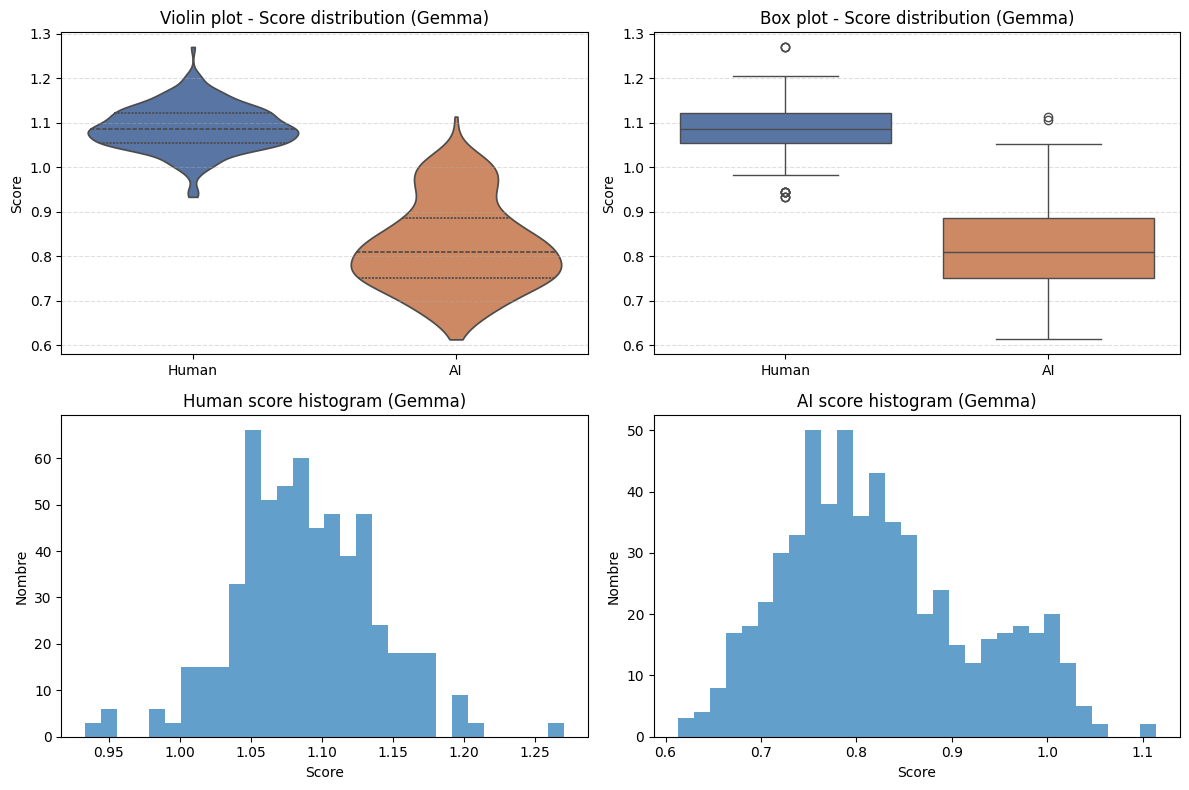

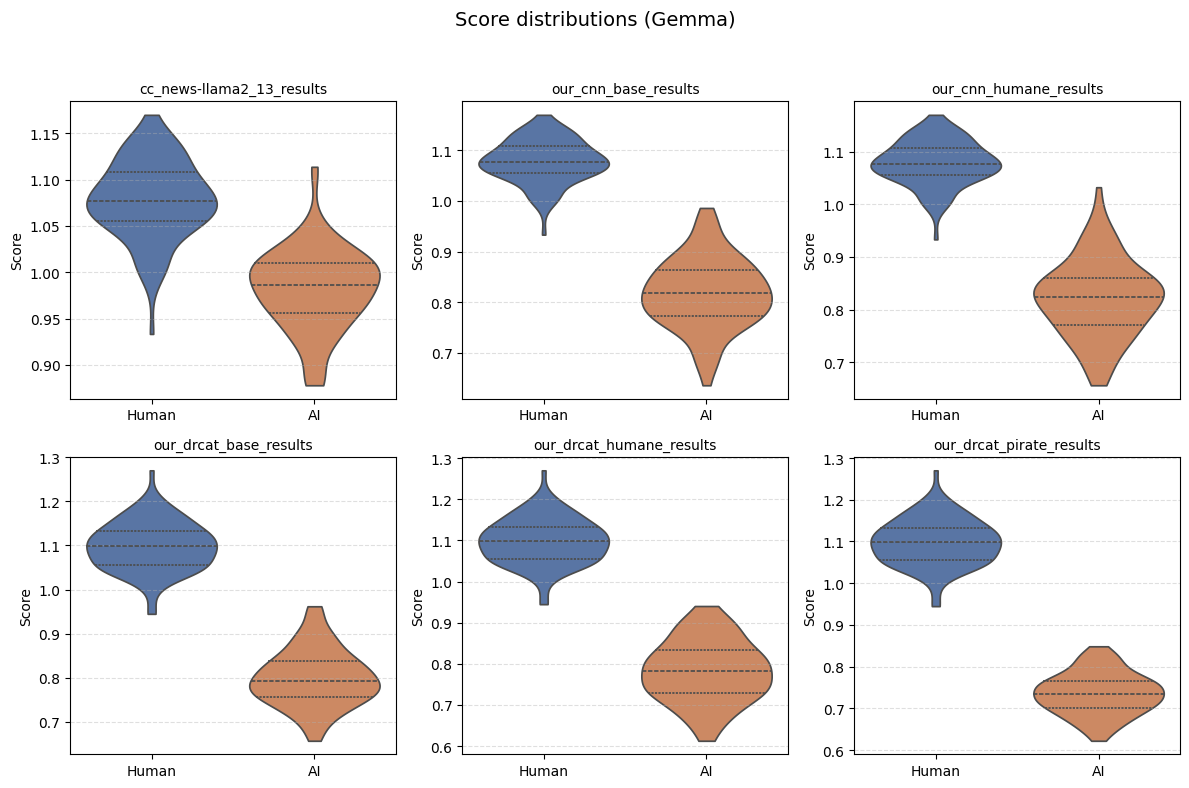

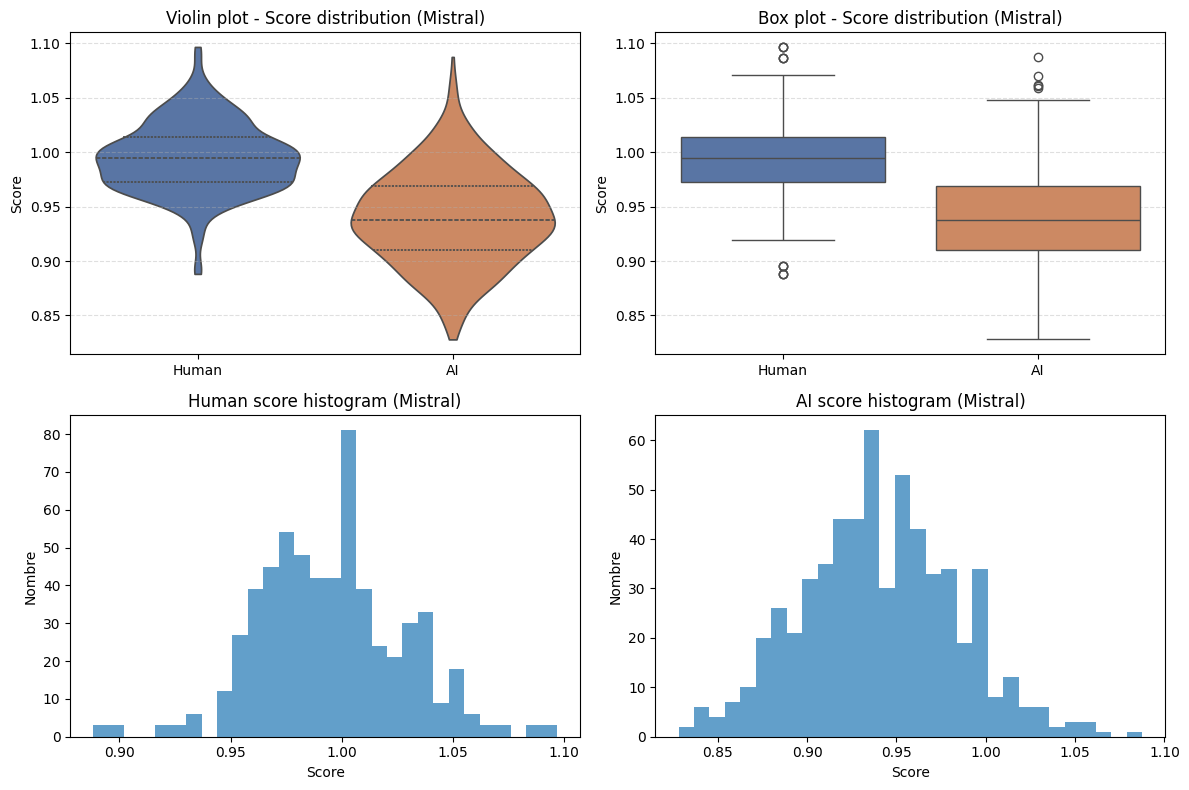

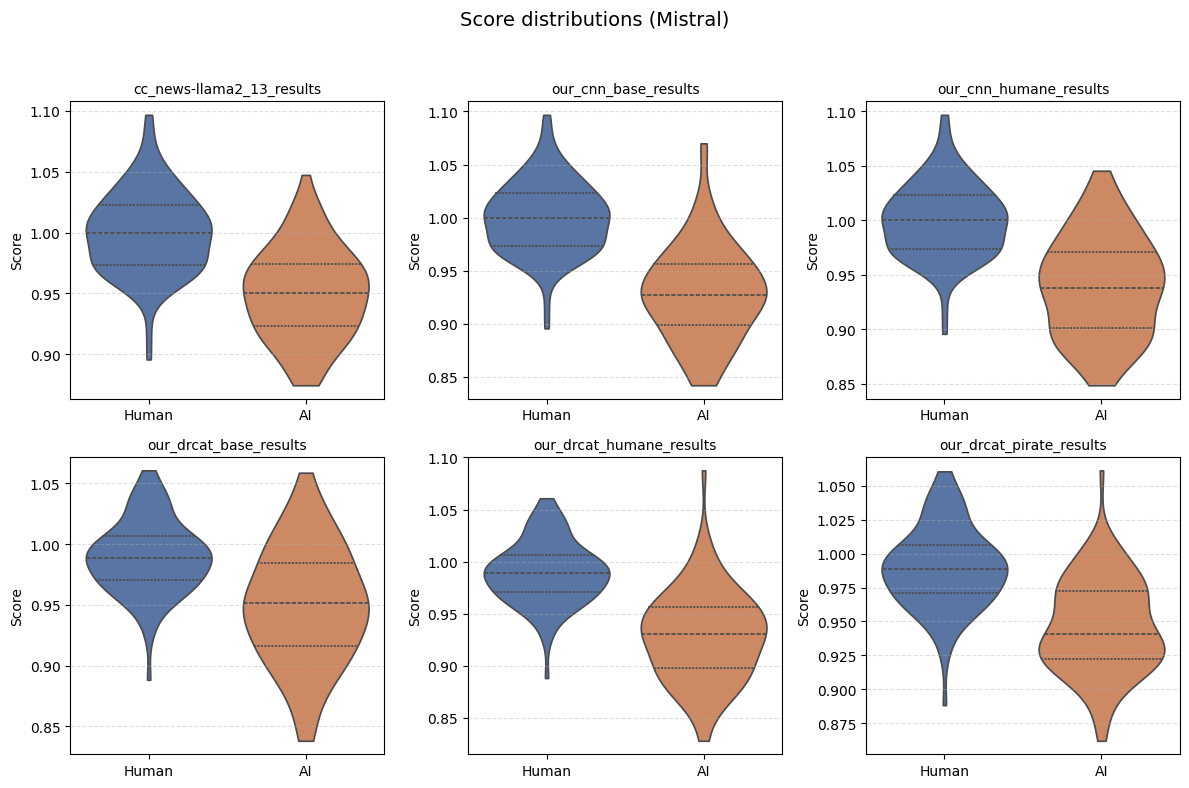

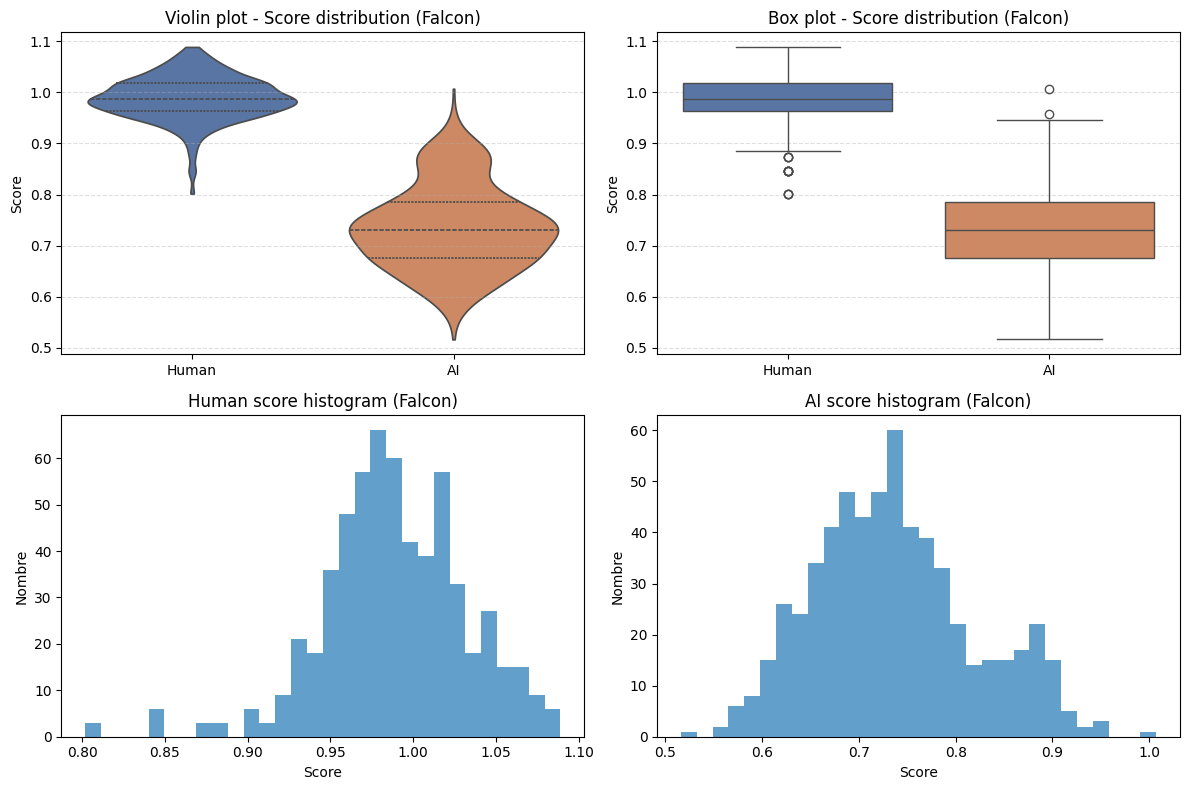

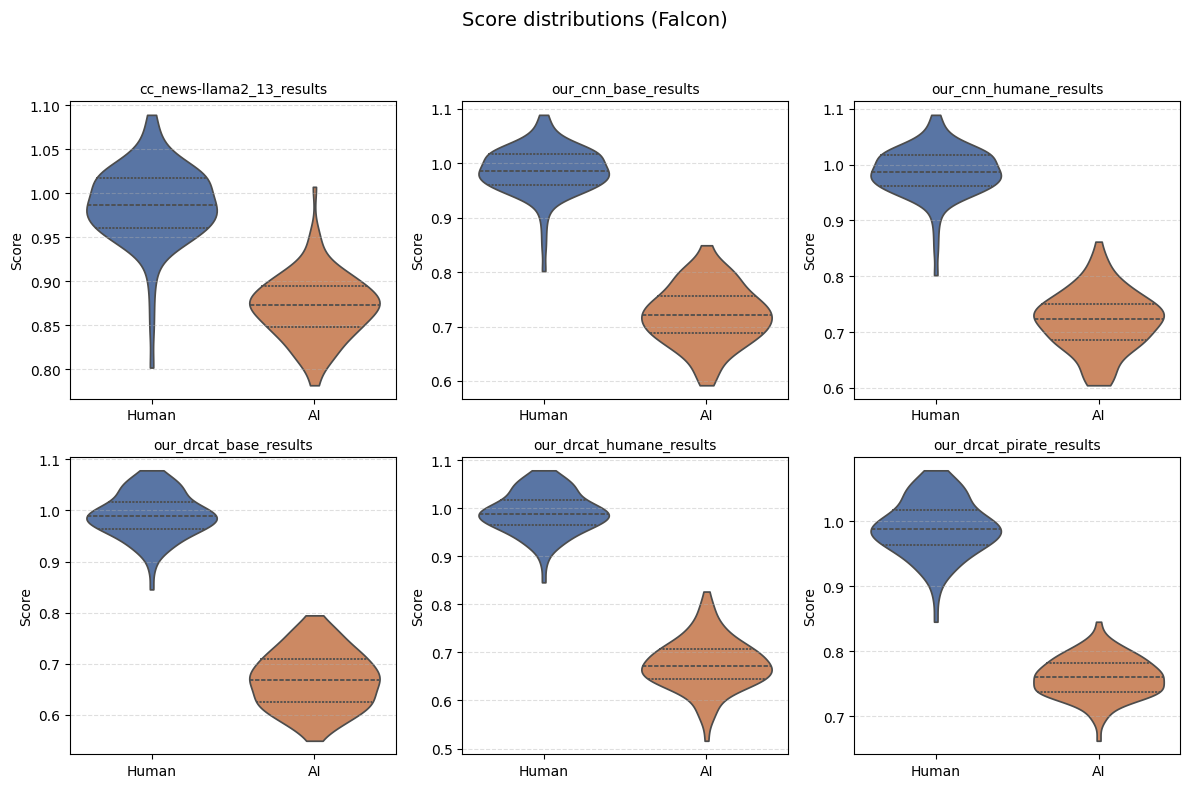

In [269]:

for model_name,output_dir in zip(model_names,output_dirs):
    df_logs = get_df_from_output(output_dir)
    df_scores = df_logs[["score","true_class", "predicted_class"]]

    # Generate plots 
    generate_plots(df_scores, model_name=model_name)
    generate_violin_plots(output_dir, model_name=model_name)


## Optimal B-Thresholds

In [270]:
from sklearn.metrics import roc_curve, precision_recall_fscore_support, accuracy_score

def optimal_thresholds(df, model_name, score_col="score", true_col="true_class", fpr_cap=0.01):
    y = df[true_col].to_numpy()
    s = df[score_col].to_numpy()
    s_ia = -s

    # IA if s < b  <=>  IA if (-s) >= (-b)
    fpr, tpr, thresholds = roc_curve(y, s_ia)

    curve = []
    best_global = None
    best_tpr_cap = None

    for fpr_i, tpr_i, thr_ia in zip(fpr, tpr, thresholds):
        b = -thr_ia  # Convert threshold back to original score space
        y_pred = (s < b).astype(int)  # Predict AI if s < b

        precision, recall, f1, _ = precision_recall_fscore_support(
            y, y_pred, average="binary", zero_division=0
        )
        acc = accuracy_score(y, y_pred)

        entry = {
            "threshold": b,
            "fpr": float(fpr_i),
            "tpr": float(tpr_i),
            "precision": float(precision),
            "recall": float(recall),
            "f1": float(f1),
            "accuracy": float(acc),
        }
        curve.append(entry)

        # Best global F1
        if best_global is None or entry["f1"] > best_global["f1"]:
            best_global = entry

        # Best TPR under FPR constraint (as in paper metric style)
        if entry["fpr"] <= fpr_cap:
            if best_tpr_cap is None or entry["tpr"] > best_tpr_cap["tpr"]:
                best_tpr_cap = entry

    # Safety: if no threshold satisfies fpr_cap, fallback to best_global
    if best_tpr_cap is None:
        best_tpr_cap = best_global

    results = {
        "model_name": model_name,

        "B_f1_opt": best_global["threshold"],
        "metrics_at_B_f1": {
            "F1": best_global["f1"],
            "Precision": best_global["precision"],
            "Recall": best_global["recall"],
            "FPR": best_global["fpr"],
            "TPR": best_global["tpr"],
            "Accuracy": best_global["accuracy"],
        },

        "B_low_fpr_opt": best_tpr_cap["threshold"],
        "metrics_at_B_low_fpr_opt": {
            "F1": best_tpr_cap["f1"],
            "TPR": best_tpr_cap["tpr"],
            "FPR": best_tpr_cap["fpr"],
            "threshold": best_tpr_cap["threshold"],
            "Accuracy": best_tpr_cap["accuracy"],
        },

        "curve": curve,
    }

    return results

# Return all results 

def optimal_thresholds_models(model_names = ["Gemma","Mistral","Falcon"], output_dirs =["output_gemini","output_ministral","output_falcon"], score_col = "score", true_col= "true_class",fpr_cap = 0.01):

    all_results = dict()
    B_opts = []

    for model_name,output_dir in zip(model_names,output_dirs,):
        df_logs = get_df_from_output(output_dir)
        df_scores = df_logs[["score","true_class", "predicted_class"]]
        all_results[model_name] = optimal_thresholds(df_scores,model_name,score_col=score_col,true_col=true_col,fpr_cap=fpr_cap)
        
        B_row = dict()
        B_row["model_name"] = model_name
        B_row["B_low_fpr_opt"] = float(all_results[model_name]["B_low_fpr_opt"])
        B_row["B_f1_opt"] = float(all_results[model_name]["B_f1_opt"])
        B_opts.append(B_row)
    

    return all_results,B_opts




#get_info_datsets(df_logs)

all_results,B_opts = optimal_thresholds_models()
print(all_results["Gemma"]['metrics_at_B_f1'].keys())
pd.DataFrame(B_opts)

dict_keys(['F1', 'Precision', 'Recall', 'FPR', 'TPR', 'Accuracy'])


,model_name,B_low_fpr_opt,B_f1_opt
0,Gemma,0.943769,1.005392
1,Mistral,0.919118,0.968254
2,Falcon,0.845671,0.918431


## ROC Curve

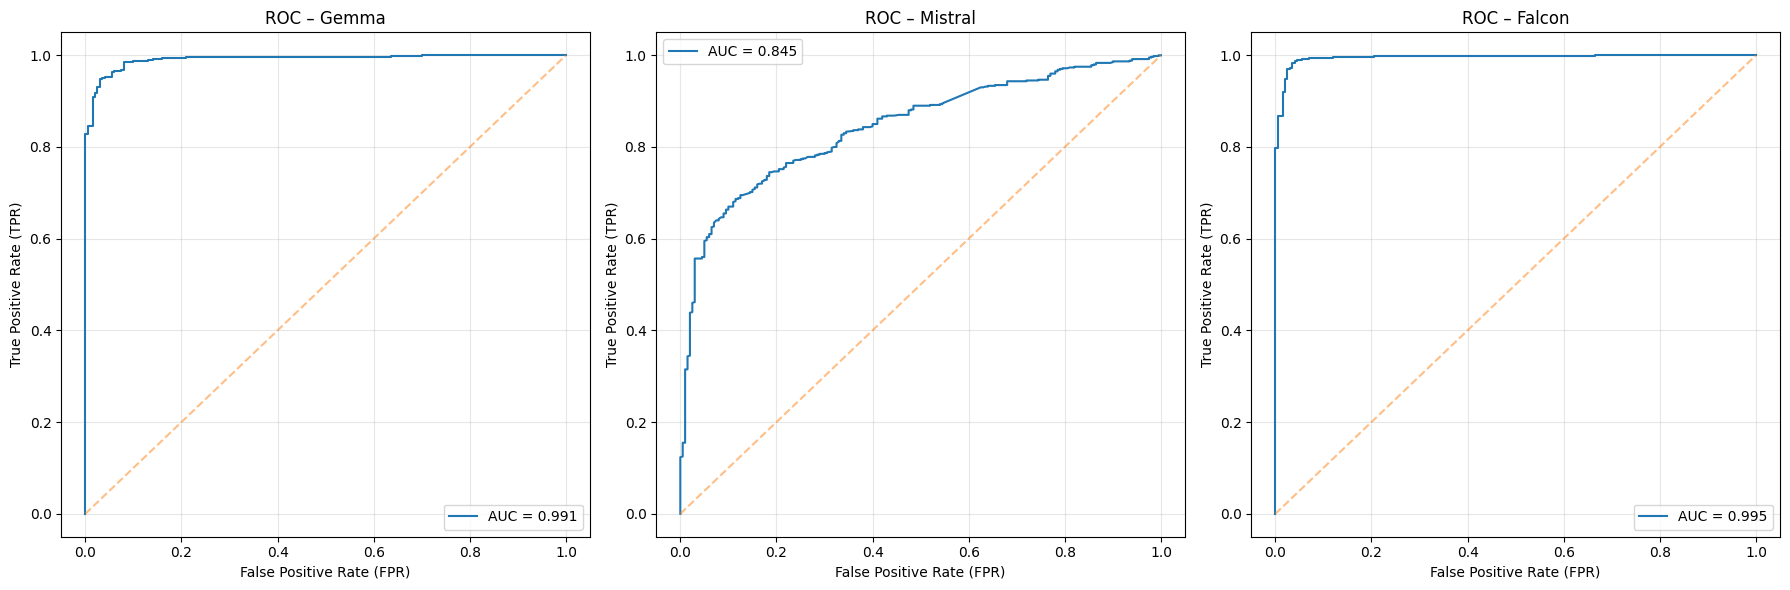

In [271]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


def plot_roc_curve_multi_models(all_results, model_names, output_dirs):

    curves = [ all_results[model_name]["curve"]for model_name in all_results]
    n_models = len(model_names)
    plt.figure(figsize=(6 * n_models, 6))

    for i, (model_name, output_dir, curve) in enumerate(zip(model_names, output_dirs, curves)):
        
        # --- Extract FPR / TPR ---
        fpr = [float(entry["fpr"]) for entry in curve]
        tpr = [float(entry["tpr"]) for entry in curve]

        roc_auc = auc(fpr, tpr)

        # --- Subplot ---
        plt.subplot(1, n_models, i + 1)
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0, 1], [0, 1], "--", alpha=0.5)

        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR)")
        plt.title(f"ROC – {model_name}")
        plt.legend()
        plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

model_names 
plot_roc_curve_multi_models(all_results, model_names, output_dirs )

## Accuracy and F1 Score

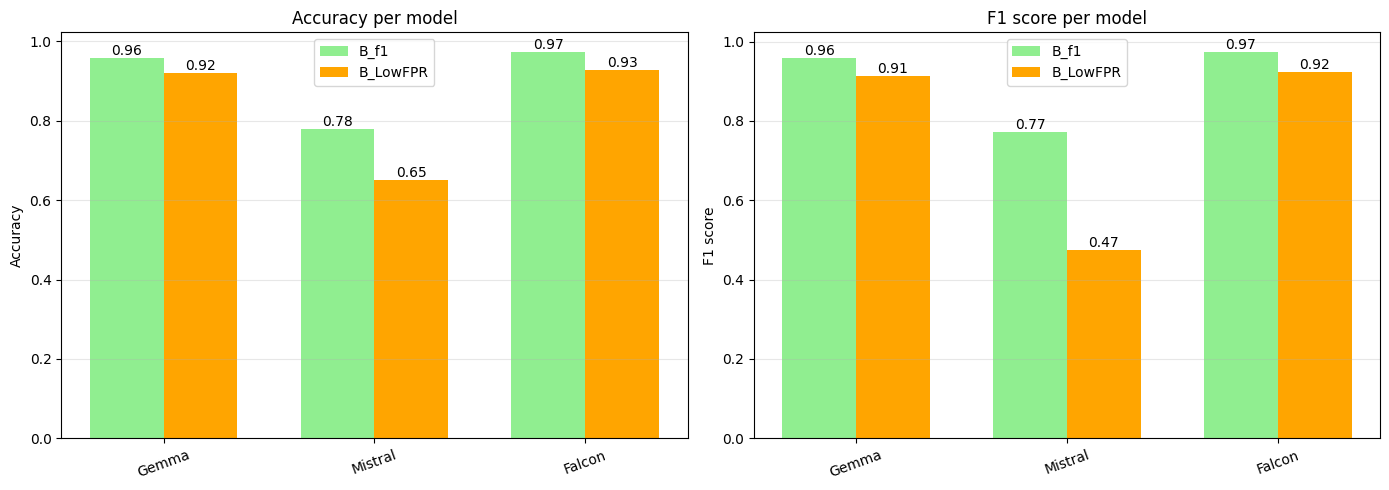

In [273]:
def plot_accuracy_and_f1_bars(all_results):

    model_names = list(all_results.keys())

    acc_bf1 = [
        all_results[m]["metrics_at_B_f1"]["Accuracy"]
        for m in model_names
    ]
    acc_lowfpr = [
        all_results[m]["metrics_at_B_low_fpr_opt"]["Accuracy"]
        for m in model_names
    ]

    f1_bf1 = [
        all_results[m]["metrics_at_B_f1"]["F1"]
        for m in model_names
    ]
    f1_lowfpr = [
        all_results[m]["metrics_at_B_low_fpr_opt"]["F1"]
        for m in model_names
    ]

    x = np.arange(len(model_names))
    width = 0.35

    plt.figure(figsize=(14, 5))

    # ---------- Accuracy subplot ----------
    plt.subplot(1, 2, 1)
    bars1=plt.bar(x - width / 2,acc_bf1,width,label="B_f1",color="lightgreen")
    bars2=plt.bar( x + width / 2,acc_lowfpr,width,label="B_LowFPR",color="orange")

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{height:.2f}",
                ha="center",
                va="bottom",
                fontsize=10
            )

    plt.xticks(x, model_names, rotation=20)
    plt.ylabel("Accuracy")
    plt.title("Accuracy per model")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)

    # ---------- F1-score subplot ----------
    plt.subplot(1, 2, 2)
    bars3 =plt.bar(x - width / 2,f1_bf1,width,label="B_f1",color="lightgreen" )
    bars4 =plt.bar(x + width / 2,f1_lowfpr,width,label="B_LowFPR",color="orange")

    for bars in [bars3, bars4]:
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{height:.2f}",
                ha="center",
                va="bottom",
                fontsize=10
            )

    plt.xticks(x, model_names, rotation=20)
    plt.ylabel("F1 score")
    plt.title("F1 score per model")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_accuracy_and_f1_bars(all_results)